# Monte Carlo sampling methods

<img src="https://risk-engineering.org/static/img/logo-RE.png" width="100" alt="" style="float:right;margin:15px;">
This notebook is an element of the [risk-engineering.org courseware](https://risk-engineering.org/). It can be distributed under the terms of the [Creative Commons Attribution-ShareAlike licence](https://creativecommons.org/licenses/by-sa/4.0/).

Author: Eric Marsden <eric.marsden@risk-engineering.org>

---

This notebook contains an introduction to different sampling methods in Monte Carlo analysis (standard random sampling, latin hypercube sampling, and low discrepency sequences such as that of Sobol’ and that of Halton). The notebook shows how to use Python, with the [SciPy](https://scipy.org/) and [SymPy](https://sympy.org/) libraries. It uses some Python 3 features. See the [lecture slides at risk-engineering.org](https://risk-engineering.org/monte-carlo-methods/) for more background information on stochastic simulation. 

In [1]:
import math
import numpy
import scipy.stats
import matplotlib.pyplot as plt

Let’s start with a simple integration problem in 1D, 

$\int_1^5 x^2$

This is easy to solve analytically, and we can use the SymPy library in case you’ve forgotten how to resolve simple integrals.

In [2]:
import sympy
result = {}  # we'll save results using different methods here
x = sympy.Symbol('x')
i = sympy.integrate(x**2)
result['analytical'] = float(i.subs(x, 5) - i.subs(x, 1))
print("Analytical result: {}".format(result['analytical']))

Analytical result: 41.333333333333336


We can estimate this integral using a standard Monte Carlo method, where we use the fact that the expectation of a random variable is related to its integral

$\mathbb{E}(f(x)) = \int_I f(x) dx$

We will sample a large number $N$ of points in $I$ and calculate their average, and multiply by the range over which we are integrating.

In [3]:
N = 10000
accum = 0
for i in range(N):
    x = numpy.random.uniform(1, 5)
    accum += x**2
volume = 5 - 1
result['MC'] = volume * accum / float(N)
print("Standard Monte Carlo result: {}".format(result['MC']))

Standard Monte Carlo result: 40.9634538942694


If we increase $N$, the estimation will converge to the analytical value. (It will converge relatively slowly, following $1/\sqrt(N)$). 

## Latin hypercube sampling

The LHS method consists of dividing the input space into a number of equiprobable regions, then taking random samples from each region. We can use it conveniently in Python thanks to the [pyDOE library](https://pythonhosted.org/pyDOE/), which you will probably need to install on your computer, using a command such as 

> pip install pyDOE

or if you’re using a Google CoLaboratory notebook, execute a code cell containing

> !pip install pyDOE

The `lhs` function in this library returns an “experimental design” consisting of points in the $[0, 1]^d$ hypercube, where $d$ is the dimension of your problem (it’s 2 in this simple example). You need to scale these points to your input domain. 

In [4]:
# obtain the pyDOE library from https://pythonhosted.org/pyDOE/
from pyDOE import lhs

seq = lhs(2, N)
accum = 0
for i in range(N):
    x = 1 + seq[i][0]*(5 - 1)
    y = 1 + seq[i][1]*(5**2 - 1**2)
    accum += x**2
volume = 5 - 1
result['LHS'] = volume * accum / float(N)
print("Latin hypercube result: {}".format(result['LHS']))

Latin hypercube result: 41.333301290132134


Note that the error in this estimation is significantly lower than that obtained using standard Monte Carlo sampling (and if you repeat this experiment many times, you should find this is true in most cases).

## Halton’s low discrepency sequences

A [low discrepency (or quasi-random) sequence](https://en.wikipedia.org/wiki/Low-discrepancy_sequence) is a deterministic mathematical sequence of numbers that has the property of low discrepency. This means that there are no clusters of points and that the sequence fills space roughly uniformly. The [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence) is a low discrepency sequence that has useful properties for pseudo-stochastic sampling methods (also called “quasi-Monte Carlo” methods). 

In [5]:
# from https://mail.scipy.org/pipermail/scipy-user/2013-June/034744.html
def halton(dim: int, nbpts: int):
    h = numpy.empty(nbpts * dim)
    h.fill(numpy.nan)
    p = numpy.empty(nbpts)
    p.fill(numpy.nan)
    P = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
    lognbpts = math.log(nbpts + 1)
    for i in range(dim):
        b = P[i]
        n = int(math.ceil(lognbpts / math.log(b)))
        for t in range(n):
            p[t] = pow(b, -(t + 1))

        for j in range(nbpts):
            d = j + 1
            sum_ = math.fmod(d, b) * p[0]
            for t in range(1, n):
                d = math.floor(d / b)
                sum_ += math.fmod(d, b) * p[t]

            h[j*dim + i] = sum_
    return h.reshape(nbpts, dim)

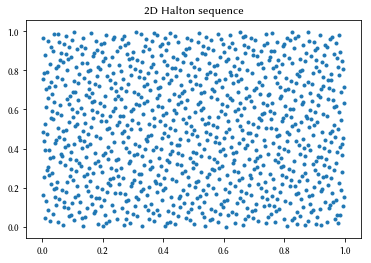

In [6]:
N = 1000
seq = halton(2, N)
plt.title("2D Halton sequence")
plt.scatter(seq[:,0], seq[:,1], marker=".");

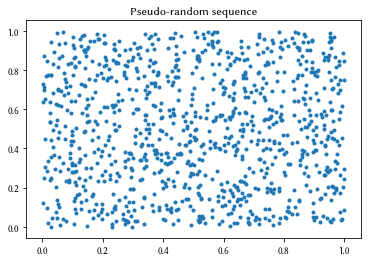

In [7]:
N = 1000
plt.title("Pseudo-random sequence")
plt.scatter(numpy.random.uniform(size=N), numpy.random.uniform(size=N), marker=".");

Comparing the scatterplot of the 2D Halton sequence with that of a pseudo-random sequence (pseudo-random meaning “as close to randomness as we can get with a computer”), note that the Halton sequence looks less “random” and covers the space in a more regular manner. For this reason, a low discrepency sequence gives, on average, better results for stochastic sampling problems than does a truly stochastic (really pseudo-random) sampling approach. Let’s test that on our integration problem:

In [8]:
seq = halton(2, N)
accum = 0
for i in range(N):
    x = 1 + seq[i][0]*(5 - 1)
    y = 1 + seq[i][1]*(5**2 - 1**2)
    accum += x**2
volume = 5 - 1
result['QMC'] = volume * accum / float(N)
print("Quasi-Monte Carlo result: {}".format(result['QMC']))

Quasi-Monte Carlo result: 41.21870562744141


Another quasi-random sequence commonly used for this purpose is the Sobol’ sequence. 

We can compare the error of our different estimates (each used the same number of runs):

In [9]:
for m in ['MC', 'LHS', 'QMC']:
    print("{:3} result: {:.8}  Error: {:E}".format(m, result[m], abs(result[m]-result['analytical'])))

MC  result: 40.963454  Error: 3.698794E-01
LHS result: 41.333301  Error: 3.204320E-05
QMC result: 41.218706  Error: 1.146277E-01


Note that in practice, it’s possible to combine Latin Hypercube sampling with low discrepency sequences.

## A higher dimensional integral

Let us now analyze an integration problem in dimension 4, the Ishigami function. This is a well-known function in numerical optimization and stochastic analysis, because it is very highly non-linear. 

In [10]:
def ishigami(x1, x2, x3) -> float:
    return numpy.sin(x1) + 7*numpy.sin(x2)**2 + 0.1 * x3**4 * numpy.sin(x1)

We want to resolve the integral over $[-\pi, \pi]^3$. We start by resolving the problem analytically, using SymPy. 

In [11]:
x1 = sympy.Symbol('x1')
x2 = sympy.Symbol('x2')
x3 = sympy.Symbol('x3')
expr = sympy.sin(x1) + 7*sympy.sin(x2)**2 + 0.1 * x3**4 * sympy.sin(x1)
res = sympy.integrate(expr,
                      (x1, -sympy.pi, sympy.pi),
                      (x2, -sympy.pi, sympy.pi),
                      (x3, -sympy.pi, sympy.pi))
result['analytical'] = float(res)

Result from a standard Monte Carlo sampling method:

In [12]:
N = 10000
accum = 0
for i in range(N):
    xx1 = numpy.random.uniform(-numpy.pi, numpy.pi)
    xx2 = numpy.random.uniform(-numpy.pi, numpy.pi)
    xx3 = numpy.random.uniform(-numpy.pi, numpy.pi)
    accum += numpy.sin(xx1) + 7*numpy.sin(xx2)**2 + 0.1 * xx3**4 * numpy.sin(xx1)
volume = (2 * numpy.pi)**3
result['MC'] = volume * accum / float(N)

Using latin hypercube sampling:

In [13]:
seq = lhs(3, N)
accum = 0
for i in range(N):
    xx1 = -numpy.pi + seq[i][0] * numpy.pi * 2
    xx2 = -numpy.pi + seq[i][1] * numpy.pi * 2
    xx3 = -numpy.pi + seq[i][2] * numpy.pi * 2
    accum += numpy.sin(xx1) + 7*numpy.sin(xx2)**2 + 0.1 * xx3**4 * numpy.sin(xx1)
volume = (2 * numpy.pi)**3
result['LHS'] = volume * accum / float(N)

A low-discrepency Halton sequence, for a quasi-Monte Carlo approach:

In [14]:
seq = halton(3, N)
accum = 0
for i in range(N):
    xx1 = -numpy.pi + seq[i][0] * numpy.pi * 2
    xx2 = -numpy.pi + seq[i][1] * numpy.pi * 2
    xx3 = -numpy.pi + seq[i][2] * numpy.pi * 2
    accum += numpy.sin(xx1) + 7*numpy.sin(xx2)**2 + 0.1 * xx3**4 * numpy.sin(xx1)
volume = (2 * numpy.pi)**3
result['QMC'] = volume * accum / float(N)

Comparing the results of the three estimation methods: 

In [15]:
for m in ['MC', 'LHS', 'QMC']:
    print("{:3} result: {:.8} Error: {:E}".format(m, result[m], abs(result[m]-result['analytical'])))

MC  result: 874.12993 Error: 5.954187E+00
LHS result: 879.01467 Error: 1.083893E+01
QMC result: 868.23893 Error: 6.318098E-02
